In [1]:
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import csv
import random

In [2]:
# BASE_PATH = "D:\OneDrive\Kuliah\SMT 6\PCD\Project Mandiri\Honey Bee Detection Model.v2-baseline.tensorflow"
# IMAGES_PATH = os.path.sep.join([BASE_PATH, "train"])
# ANNOTS_PATH = os.path.sep.join([BASE_PATH, "train\_annotations.csv"])

In [3]:
TRAINING_FILE = r"D:\OneDrive\Kuliah\SMT 6\PCD\Project Mandiri\Honey Bee Detection Model.v2-baseline.tensorflow\train\_annotations.csv"
TEST_FILE = r"D:\OneDrive\Kuliah\SMT 6\PCD\Project Mandiri\Honey Bee Detection Model.v2-baseline.tensorflow\test\_annotations.csv"
VALIDATION_FILE = r"D:\OneDrive\Kuliah\SMT 6\PCD\Project Mandiri\Honey Bee Detection Model.v2-baseline.tensorflow\valid\_annotations.csv"

In [4]:
data = []
labels = []
bboxes = []
imagePaths = []

In [5]:
def parse_data_from_input(filename):
    with open(filename) as file:
        csv_reader = csv.reader(file, delimiter=',')
        
        labels = []
        bboxes = []
        image_filenames = []

        next(csv_reader)

        for row in csv_reader:
            
            if not row or len(row) < 8:  
                continue

            image_filename = row[0]
            width = int(row[1])
            height = int(row[2])
            class_name = row[3]
            xmin = int(row[4]) / width
            ymin = int(row[5]) / height
            xmax = int(row[6]) / width
            ymax = int(row[7]) / height
            
            labels.append(class_name) 
            bboxes.append([xmin, ymin, xmax, ymax])
            image_filenames.append(image_filename)

        labels = np.array(labels)
        bboxes = np.array(bboxes)
        image_filenames = np.array(image_filenames)

        return image_filenames, labels, bboxes

In [6]:
def load_images_and_annotations(image_filenames, labels, bboxes, dataset_dir):
    images = []
    new_labels = []
    new_bboxes = []

    for i, filename in enumerate(image_filenames):
        image_path = os.path.join(dataset_dir, filename)
        image = cv2.imread(image_path)
        if image is not None:
            resized_image = cv2.resize(image, (256, 256))
            images.append(resized_image)
            new_labels.append(labels[i])
            new_bboxes.append(bboxes[i])
        else:
            print(f"Warning: Image at path {image_path} could not be loaded.")
    images = np.array(images).astype('float32')
    new_labels = np.array(new_labels)
    new_bboxes = np.array(new_bboxes)

    return images, new_labels, new_bboxes

In [7]:
training_image_filenames, training_labels, training_bboxes = parse_data_from_input(TRAINING_FILE)
test_image_filenames, testing_labels, testing_bboxes = parse_data_from_input(TEST_FILE)
validation_image_filenames, validation_labels, validation_bboxes = parse_data_from_input(VALIDATION_FILE)

print(f"Training image filenames has shape: {training_image_filenames.shape} and dtype: {training_image_filenames.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Training bounding boxes has shape: {training_bboxes.shape} and dtype: {training_bboxes.dtype}")
print("===============================================================================================================")
print(f"Testing image filenames has shape: {test_image_filenames.shape} and dtype: {test_image_filenames.dtype}")
print(f"Testing labels has shape: {testing_labels.shape} and dtype: {testing_labels.dtype}")
print(f"Testing bounding boxes has shape: {testing_bboxes.shape} and dtype: {testing_bboxes.dtype}")
print("===============================================================================================================")
print(f"Validation image filenames has shape: {validation_image_filenames.shape} and dtype: {validation_image_filenames.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")
print(f"Validation bounding boxes has shape: {validation_bboxes.shape} and dtype: {validation_bboxes.dtype}")

Training image filenames has shape: (3266,) and dtype: <U171
Training labels has shape: (3266,) and dtype: <U9
Training bounding boxes has shape: (3266, 4) and dtype: float64
Testing image filenames has shape: (971,) and dtype: <U121
Testing labels has shape: (971,) and dtype: <U9
Testing bounding boxes has shape: (971, 4) and dtype: float64
Validation image filenames has shape: (1264,) and dtype: <U163
Validation labels has shape: (1264,) and dtype: <U9
Validation bounding boxes has shape: (1264, 4) and dtype: float64


In [8]:
imgDatasetTrain = r"D:\OneDrive\Kuliah\SMT 6\PCD\Project Mandiri\Honey Bee Detection Model.v2-baseline.tensorflow\train"
imgDatasetTest = r"D:\OneDrive\Kuliah\SMT 6\PCD\Project Mandiri\Honey Bee Detection Model.v2-baseline.tensorflow\test"

In [9]:
training_image2s, training_labels2, training_bboxes2 = load_images_and_annotations(training_image_filenames, training_labels, training_bboxes, imgDatasetTrain)
test_images2, testing_labels2, testing_bboxes2 = load_images_and_annotations(test_image_filenames, testing_labels, testing_bboxes, imgDatasetTest)

In [10]:
# trainImages = np.expand_dims(training_image2s, axis=-1)
# testImages = np.expand_dims(test_images2, axis=-1)

In [11]:
print("Shape:", training_image2s.shape) 
print("Shape:", training_labels2.shape)  
print("Shape:", training_bboxes2.shape)  # Or testImages.shape


Shape: (3265, 256, 256, 3)
Shape: (3265,)
Shape: (3265, 4)


In [12]:
data = np.array(training_image2s, dtype="float32") / 255.0
labels = training_labels2
bboxes = np.array(training_bboxes, dtype="float32")


In [13]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [46]:
indeks = 0
label_sesuai_indeks = lb.classes_[indeks]
print("Label sesuai dengan indeks", indeks, ":", label_sesuai_indeks)

Label sesuai dengan indeks 0 : bee


In [14]:
print(labels)

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [15]:
min_length = min(len(data), len(labels), len(bboxes))
data = data[:min_length]
labels = labels[:min_length]
bboxes = bboxes[:min_length]
split_index = int(0.8 * len(data))

trainImages = data[:split_index]
testImages = data[split_index:]
trainLabels = labels[:split_index]
testLabels = labels[split_index:]
trainBBoxes = bboxes[:split_index]
testBBoxes = bboxes[split_index:]

print(f"Train images shape: {trainImages.shape}")
print(f"Test images shape: {testImages.shape}")
print(f"Train labels shape: {trainLabels.shape}")
print(f"Test labels shape: {testLabels.shape}")
print(f"Train bounding boxes shape: {trainBBoxes.shape}")
print(f"Test bounding boxes shape: {testBBoxes.shape}")

Train images shape: (2612, 256, 256, 3)
Test images shape: (653, 256, 256, 3)
Train labels shape: (2612, 4)
Test labels shape: (653, 4)
Train bounding boxes shape: (2612, 4)
Test bounding boxes shape: (653, 4)


In [16]:
# trainLabels = to_categorical(trainLabels, num_classes=4)
# testLabels = to_categorical(testLabels, num_classes=4)

In [17]:
# Print the shape and a few examples of trainLabels
print(f"Original trainLabels shape: {trainLabels.shape}")
print(trainLabels[:5])  # Print first 5 elements to inspect

# Print the shape and a few examples of testLabels
print(f"Original testLabels shape: {testLabels.shape}")
print(testLabels[:5])  # Print first 5 elements to inspect


Original trainLabels shape: (2612, 4)
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]]
Original testLabels shape: (653, 4)
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [18]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(256, 256, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

In [19]:
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(4, activation="softmax",
	name="class_label")(softmaxHead)

model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [20]:
model.compile(loss={"class_label": "categorical_crossentropy","bounding_box": "mean_squared_error",}, 
              optimizer=Adam(learning_rate=0.001), 
              metrics={'bounding_box': 'mse', 'class_label': 'accuracy'}, 
              loss_weights={"class_label": 1.0,"bounding_box": 1.0}
              )
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 35,962,024 (137.18 MB)

 Trainable params: 21,247,336 (81.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [21]:
trainTargets = {"class_label": trainLabels,"bounding_box": trainBBoxes}
testTargets = {"class_label": testLabels,"bounding_box": testBBoxes}

In [22]:
H = model.fit(trainImages, trainTargets,validation_data=(testImages, testTargets),batch_size=32,epochs=5,verbose=1)

[INFO] training model...
Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 685s 8s/step - bounding_box_mse: 0.0547 - class_label_accuracy: 0.7737 - loss: 3.1527 - val_bounding_box_mse: 0.0505 - val_class_label_accuracy: 0.9081 - val_loss: 0.4997
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 705s 9s/step - bounding_box_mse: 0.0368 - class_label_accuracy: 0.8167 - loss: 0.7216 - val_bounding_box_mse: 0.0479 - val_class_label_accuracy: 0.9066 - val_loss: 0.3846
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 733s 9s/step - bounding_box_mse: 0.0332 - class_label_accuracy: 0.8562 - loss: 0.5639 - val_bounding_box_mse: 0.0455 - val_class_label_accuracy: 0.9066 - val_loss: 0.4115
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 652s 8s/step - bounding_box_mse: 0.0342 - class_label_accuracy: 0.8637 - loss: 0.5571 - val_bounding_box_mse: 0.0454 - val_class_label_accuracy: 0.9066 - val_loss: 0.3881
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 484s 6s/step - bounding_box_mse: 0.0333 - class_label_accuracy: 0.8858 - loss: 0.4861 - val_bounding_box_m

In [31]:
model.save("fatha.h5")

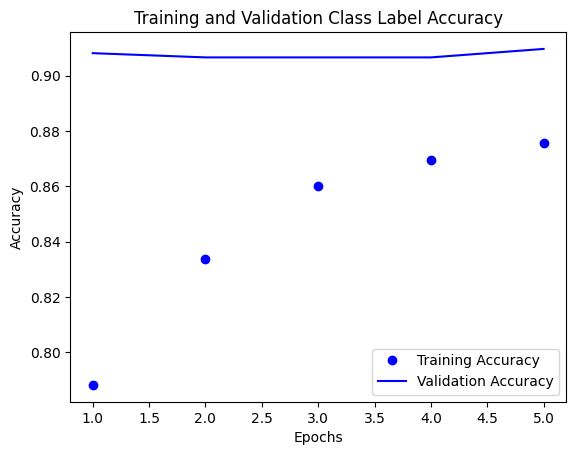

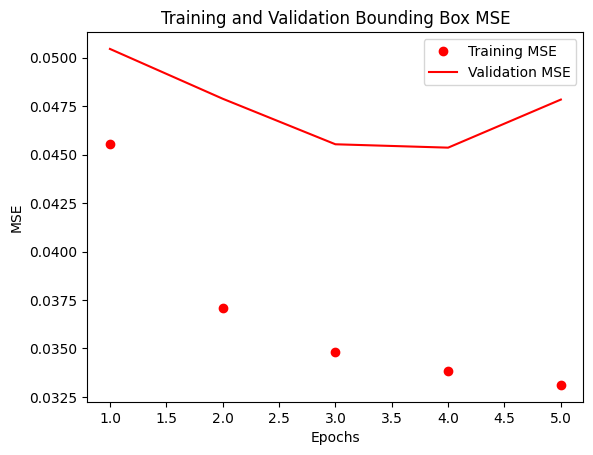

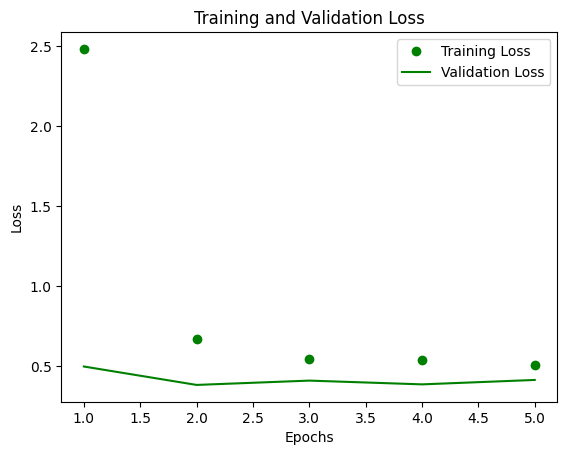

In [25]:

bounding_box_mse = H.history['bounding_box_mse']
val_bounding_box_mse = H.history['val_bounding_box_mse']
class_label_accuracy = H.history['class_label_accuracy']
val_class_label_accuracy = H.history['val_class_label_accuracy']
loss = H.history['loss']  
val_loss = H.history['val_loss']  
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, class_label_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_class_label_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Class Label Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, bounding_box_mse, 'ro', label='Training MSE')
plt.plot(epochs, val_bounding_box_mse, 'r', label='Validation MSE')
plt.title('Training and Validation Bounding Box MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [45]:
def prepare_image(image_path):
    image = cv2.imread(image_path)
    original_dim = (image.shape[1], image.shape[0])
    resized_image = cv2.resize(image, (256, 256))
    resized_image = img_to_array(resized_image) / 255.0
    resized_image = np.expand_dims(resized_image, axis=0)
    return resized_image, original_dim, image

def draw_bounding_box(image, bounding_box, class_label, color=(0, 255, 0), thickness=2):
    (startX, startY, endX, endY) = bounding_box
    cv2.rectangle(image, (startX, startY), (endX, endY), color, thickness)
    text = f"Class: {class_label}"
    cv2.putText(image, text, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return image

H = model
image_path = 'test.jpg'
resized_image, original_dim, original_image = prepare_image(image_path)
predictions = H.predict(resized_image)
bounding_box = predictions[0][0]
class_label = predictions[1][0] 

(startX, startY, endX, endY) = (bounding_box[0], bounding_box[1], bounding_box[2], bounding_box[3])
startX = int(startX * original_dim[0])
startY = int(startY * original_dim[1])
endX = int(endX * original_dim[0])
endY = int(endY * original_dim[1])

output_image = draw_bounding_box(original_image, (startX, startY, endX, endY), class_label)

cv2.imshow('Image with Bounding Box', output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
